# Proteomic Data Aggregation and Visualization


This notebook demonstrates aggregation of proteomic data via the National Microbiome Data Collaborative (NMDC)'s [Runtime API](https://api.microbiomedata.org/docs). It highlights how the NMDC's schema can be used to overcome some of the numerous challenges associated with this type of aggregation and provides an example proteomic analysis which links these results to other datasets in NMDC. Please note that this notebook is intended for individuals with experience performing mass spectrometry based analyses and that various parameter and processing choices were made for this example use case. They are not broadly applicable and should be adjusted as needed. 


Notebook Steps:

1) Assess background information and collect datasets for an example study of riverbed sediment along the Columbia River

2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

3) Collapse to unique peptides and normalize quantification

4) Generate protein mappings using both "Razor" and "Sorted List" strategies

5) Perform protein rollup using the "Sorted List" results and summarize into an aggregated table of relative protein abundance

6) Find additional datasets across omics types in NMDC that share relevant KEGG IDs with this study


Import libraries and python scripts containing functions necessary to run this notebook. 'aggregation_functions.py' (also in this folder) includes spectral probability filtering and protein mapping functions. 'nmdc_api.py' (located in NOM_visualization/python) includes functions for API traversal of the collections endpoint

In [2]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

#module in this folder with specific protein aggregation functions
import aggregation_functions as agg_func

#module for API functions currently residing in NOM_visualizations
api_func=agg_func.import_relative_module("nmdc_api", "../../NOM_visualizations/python/nmdc_api.py")

## 1) Assess background information and collect data for an example study of riverbed sediment along the Columbia River

Review the example study on the [NMDC data portal](https://data.microbiomedata.org/details/study/nmdc:sty-11-aygzgv51). Use the study `id` embedded in the url (nmdc:sty-11-aygzgv51) to collect all related data objects via the [NMDC Runtime API](https://api.microbiomedata.org/docs) and reformat the yaml output into a pandas dataframe

In [3]:
pd.set_option("display.max_rows", 6)

#get all data objects associated with this study id using the NMDC find endpoint
og_url = f'https://api.microbiomedata.org/data_objects/study/nmdc:sty-11-aygzgv51?&max_page_size=100'
resp = requests.get(og_url)
data = resp.json()
data = pd.DataFrame(data)
del resp, og_url

#reformat data into dataframe (keeping biosample id)
data_objects=[]
for index, row in data.iterrows():
    bio_id = row['biosample_id']
    row_out = row.explode('data_objects').drop_duplicates()
    row_out = pd.json_normalize(row_out)
    row_out['biosample_id'] = bio_id
    data_objects.append(row_out)

data_objects = pd.concat(data_objects)
display(data_objects)

del data, index, row, row_out, bio_id

,id,name,description,file_size_bytes,data_object_type,type,md5_checksum,url,was_generated_by,biosample_id,alternative_identifiers,in_manifest,data_category
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nmdc:bsm-13-amrnys72,NaN,NaN,NaN
1,nmdc:dobj-13-f605mj12,9289.1.128215.TCCTGAG-TATCCTC.fastq.gz,Raw sequencer read data,6.700068e+09,Metagenome Raw Reads,nmdc:DataObject,NaN,NaN,NaN,nmdc:bsm-13-amrnys72,NaN,NaN,NaN
2,nmdc:dobj-13-20vg7p81,nmdc_wfmgas-13-01678h03.1_contigs.fna,Assembled contigs fasta for nmdc:omprc-13-g765...,2.507473e+08,Assembly Contigs,nmdc:DataObject,3d9e14d6f7a854042a7d71def080409b,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-amrnys72,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,nmdc:dobj-13-a1288f79,Unground_SBR_Spring_2014_FC_S3_50-60_H2Oext_22...,EnviroMS FT ICR-MS natural organic matter work...,1.399500e+04,FT ICR-MS Analysis Results,nmdc:DataObject,32d61ae97aae206e3a0a659ac26c9207,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-y8faan47.1,nmdc:bsm-13-7sbt2x61,NaN,NaN,NaN
9,nmdc:dobj-13-h2j6dr08,output: Unground_SBR_Spring_2014_FC_S3_50-60_M...,High resolution MS spectra only,3.052338e+07,NaN,nmdc:DataObject,NaN,NaN,NaN,nmdc:bsm-13-7sbt2x61,[emsl:output_457949],NaN,NaN
10,nmdc:dobj-13-p84dp061,Unground_SBR_Spring_2014_FC_S3_50-60_MeOHExt_2...,EnviroMS FT ICR-MS natural organic matter work...,8.462700e+04,FT ICR-MS Analysis Results,nmdc:DataObject,719a8a2b088256e51518f63641ea197e,https://nmdcdemo.emsl.pnnl.gov/nom/results/Ung...,nmdc:wfnom-13-q5accv31.1,nmdc:bsm-13-7sbt2x61,NaN,NaN,NaN


Subset the data objects to 'Unfiltered Metaproteomic Results'. These files contain the proteomic workflow outputs that will be used for proteomic aggregation

In [4]:
proteomic_output_df = data_objects[data_objects['data_object_type']=='Unfiltered Metaproteomics Results'].reset_index(drop=True)
display(proteomic_output_df)

,id,name,description,file_size_bytes,data_object_type,type,md5_checksum,url,was_generated_by,biosample_id,alternative_identifiers,in_manifest,data_category
0,nmdc:dobj-11-wcn69x37,nmdc_dobj-11-rrmg7w64_nmdc_dobj-11-532pnk74_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",7698320.0,Unfiltered Metaproteomics Results,nmdc:DataObject,bdc3191137d45d54afabca583205a872,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-kcdh3w94,NaN,[nmdc:manif-11-7796sg87],NaN
1,nmdc:dobj-11-bxyvx506,nmdc_dobj-11-xvmb4058_nmdc_dobj-11-bvya7a43_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",10580159.0,Unfiltered Metaproteomics Results,nmdc:DataObject,205bc0ca0620058a156011681d07832d,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-1p0tct86,NaN,[nmdc:manif-11-7796sg87],NaN
2,nmdc:dobj-11-z8hc0j30,nmdc_dobj-11-hp2vmj63_nmdc_dobj-11-716e7y35_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",8376109.0,Unfiltered Metaproteomics Results,nmdc:DataObject,8785b9538d977a50fd35d11bfcb037ce,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-2fw5j754,NaN,[nmdc:manif-11-7796sg87],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,nmdc:dobj-11-7psagy79,nmdc_dobj-11-erc74h90_nmdc_dobj-11-sekqwq68_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",10282205.0,Unfiltered Metaproteomics Results,nmdc:DataObject,7f35ff00b17f0d4e2bd5e62181005f43,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-3pvn5d70,NaN,[nmdc:manif-11-7796sg87],NaN
31,nmdc:dobj-11-tk9hc081,nmdc_dobj-11-e2309414_nmdc_dobj-11-0f1b2t61_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",8161710.0,Unfiltered Metaproteomics Results,nmdc:DataObject,4c9d199ca4c13e095a3d5caec558da9b,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-amdcp906,NaN,[nmdc:manif-11-7796sg87],NaN
32,nmdc:dobj-11-2szyc560,nmdc_dobj-11-tezmee57_nmdc_dobj-11-w2c1ee09_ms...,"Aggregation of analysis tools {MSGFplus, MASIC...",8117239.0,Unfiltered Metaproteomics Results,nmdc:DataObject,fd8a212ad33a8162857d0ca164760333,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...,NaN,nmdc:bsm-13-vqk1y255,NaN,[nmdc:manif-11-7796sg87],NaN


There are various requirements that enable mass spectrometry runs to be aggregated and analyzed together. For example, runs need to be performed in succession, on the same instrument. The NMDC schema can make it easier to find these proteomic results by linking them via a slot called `in_manifest`.

Look at the `in_manifest` id on these proteomic outputs and pull the manifest record. If that manifest record's `manifest_category` value is 'instrument_run', then it confirms that these are LC-MS/MS runs that were performed in succession on the same instrument

In [ ]:
#extract in_manifest id from this study (in this case a single one available)
manifest_id = proteomic_output_df.explode('in_manifest')['in_manifest'].unique()

#determine manifest_category
manifest = api_func.get_id_results(newest_results=proteomic_output_df.to_dict(orient='records'), id_field = 'in_manifest', query_collection = 'manifest_set', match_id_field = 'id', query_fields = '')
display(manifest)

[{'id': 'nmdc:manif-11-7796sg87',
  'manifest_category': 'instrument_run',
  'type': 'nmdc:Manifest',
  'description': 'collection of metaproteomic analyses from the same instrument run nmdc:sty-11-aygzgv51'}]

Look at an example of the information in 'Unfiltered Metaproteomics Results', which contains peptide identification and relative abundance information

In [6]:
#example unfiltered results 
unfilt_results = proteomic_output_df.iloc[0]["url"]
print(unfilt_results)

#pull data as TSV using url
for tsv in [unfilt_results]:
    response = requests.get(tsv)
    data = StringIO(response.text)
    df = pd.read_csv(data,sep='\t')
    data.close()
    display(df)
    del response, data, df, tsv

del unfilt_results

https://nmdcdemo.emsl.pnnl.gov/proteomics/results/nmdc_dobj-11-rrmg7w64_nmdc_dobj-11-532pnk74_msgfplus_syn_PlusSICStats.txt


,ResultID,Scan,FragMethod,SpecIndex,Charge,PrecursorMZ,DelM,DelM_PPM,MH,Peptide,...,PeakMaxIntensity,PeakSignalToNoiseRatio,FWHMInScans,PeakArea,ParentIonIntensity,ParentIonMZ,StatMomentsArea,PeakScanStart,PeakScanEnd,PeakWidthMinutes
0,1,36395,HCD,1,2,1098.00403,0.00318,1.44939,2193.994250,K.SAYPGQITSNMFCAGYLEGGK.D,...,242049.0,85.520,268,1.641300e+07,85675.0,1098.00,8.999200e+06,36001,36752,0
1,2,23937,HCD,2,3,721.68903,-0.00384,-1.77602,2163.056312,R.LGEDNINVVEGNEQFISASK.S,...,223900000.0,903.800,81,1.989200e+10,2994700.0,721.69,1.823700e+10,23819,24330,0
2,3,45758,HCD,3,2,1082.52820,-0.01067,-4.93472,2163.056312,R.LGEDNINVVEGNEQFISASK.S,...,1841600.0,5.298,334,5.948800e+08,1279900.0,1082.53,4.077900e+08,45649,46197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31923,31924,6605,HCD,26743,2,590.77094,-0.01103,-9.35603,1179.542201,R.MLDGDTERSR.H,...,172138.0,10.310,115,8.929200e+06,134262.0,590.77,3.611600e+06,6472,6623,0
31924,31925,25719,HCD,26744,2,1173.53979,-0.03561,-15.18653,2346.107833,-.KIEMHFLPDVYVPCETCHGK.R,...,239975.0,58.450,6,4.310700e+06,1304.7,1173.54,1.346400e+06,25637,25838,0
31925,31926,12373,HCD,26745,2,753.36945,0.01674,11.11853,1506.718237,R.EELDDPVRSQYR.E,...,484543.0,4.170,83,4.875100e+07,530695.0,753.37,1.752300e+07,12240,12401,0


Extract information from all 33 proteomic results via the function tsv_extract() in agg_func, and put them into a single dataframe, where each scan in each dataset has the unique identifier `SpecID`

In [7]:
unfilt_res = agg_func.tsv_extract(identifier_col='id',\
                                url_col='url',\
                                extract_cols=['Charge','Scan','Peptide','Protein','MSGFDB_SpecEValue','StatMomentsArea'],\
                                pd_df=proteomic_output_df,\
                                header='infer'
                            )

#create identifier for each scan in each dataset
unfilt_res["SpecID"] = unfilt_res.apply(lambda row: str(row["id_col"]) + "_" + str(row["Scan"]), axis=1)

#clean off the prefix and postfix from the sequence but keep any mods
unfilt_res["Peptide Sequence with Mods"] = unfilt_res["Peptide"].apply(agg_func.sequence_nopostpre)
del unfilt_res['Peptide']

#determine protein type (contaminant, reverse, forward)
unfilt_res["Protein_Type"] = unfilt_res["Protein"].apply(agg_func.findproteinname)

unfilt_res

,Charge,Scan,Protein,MSGFDB_SpecEValue,StatMomentsArea,id_col,SpecID,Peptide Sequence with Mods,Protein_Type
0,2,36395,Contaminant_TRYP_BOVIN,1.754200e-23,8.999200e+06,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_36395,SAYPGQITSNMFCAGYLEGGK,None
1,3,23937,Contaminant_TRYP_BOVIN,1.322500e-22,1.823700e+10,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_23937,LGEDNINVVEGNEQFISASK,None
2,2,45758,Contaminant_TRYP_BOVIN,2.022700e-22,4.077900e+08,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-wcn69x37_45758,LGEDNINVVEGNEQFISASK,None
...,...,...,...,...,...,...,...,...,...
1040341,3,31259,XXX_nmdc:wfmgan-11-z0raab34.1_062580_2_376,4.998500e-07,2.905500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_31259,MNAAEANSHADPDHMGAISVATRLGELPHANK,Reversed
1040342,2,10035,nmdc:wfmgan-11-z0raab34.1_157112_40_279,4.998700e-07,5.271900e+09,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_10035,APDLMIFAK,Forward
1040343,3,4075,XXX_nmdc:wfmgan-11-z0raab34.1_020416_230_607,4.999200e-07,9.764500e+07,nmdc:dobj-11-2szyc560,nmdc:dobj-11-2szyc560_4075,EAESEEFRQRAK,Reversed


## 2) Apply a spectral probability filter across the data that optimizes the number of identifications for an FDR of 0.05

A challenge associated with aggregating mass spectrometry data is that there is always some level of 'noise'. That noise is largely removed by imposing a spectral probability filter on the data being analyzed, and the same spectral probabililty filter needs to be applied across datasets when they are being compared. The filter value itself is chosen by weighing the number of 'true' identifications retained with the proximity of the data to a chosen false discovery rate (FDR) (usually 0.05 or 0.01). NMDC's metaproteomic workflow provides 'true' and 'false' identifications for FDR estimation in the 'Unfiltered Metaproteomic Result' files.

Create a dataframe of peptide identifications (ignoring protein mapping). Filter identifications to the peptide sequence with the smallest SpecEValue for each SpecID, so there is a single identification for each scan

In [38]:
edata = unfilt_res[['SpecID','Peptide Sequence with Mods','MSGFDB_SpecEValue','Protein_Type','StatMomentsArea']].drop_duplicates()  # important to remove any duplicated rows here!

#for each SpecID, select the peptide spectrum match with the smallest MSGFDB_SpecEValue (.idxmin() takes the first entry when there's multiple matches)
idx = edata.groupby(['SpecID'])['MSGFDB_SpecEValue'].idxmin()
edata = edata.loc[idx].reset_index(drop=True)
del idx

display(edata)

assert len(edata['SpecID'].unique())==edata.shape[0], "still more than one identification per scan"

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,Protein_Type,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,Forward,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,Forward,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,Forward,5.731600e+07
...,...,...,...,...,...
874556,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,Reversed,6.141800e+06
874557,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,Reversed,4.143000e+07
874558,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,Forward,2.284500e+06


Create separate dataframes of forward and reverse peptide spectrum matches

In [39]:
forward_peptides = edata[edata["Protein_Type"] == "Forward"].copy().reset_index(drop=True)
del forward_peptides["Protein_Type"]
display(forward_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10005,PPDERERSEEAEKRDEERDRVRDELLAGAEEGEPR,4.994300e-07,1.238500e+09
1,nmdc:dobj-11-2k6s1505_10008,LRAGSEPR,1.172600e-07,1.234600e+08
2,nmdc:dobj-11-2k6s1505_10009,WAKEIENQK,2.473900e-07,5.731600e+07
...,...,...,...,...
441013,nmdc:dobj-11-zn9eyg46_9959,DAVSGRHHAQGR,6.589700e-09,1.566600e+07
441014,nmdc:dobj-11-zn9eyg46_9967,FYRFSGR,1.080500e-07,3.418000e+08
441015,nmdc:dobj-11-zn9eyg46_9980,RFEECERECK,1.126600e-07,2.284500e+06


In [40]:
reversed_peptides = edata[edata["Protein_Type"] == "Reversed"].copy().reset_index(drop=True)
del reversed_peptides["Protein_Type"]
del edata
display(reversed_peptides)

,SpecID,Peptide Sequence with Mods,MSGFDB_SpecEValue,StatMomentsArea
0,nmdc:dobj-11-2k6s1505_10013,EFVDIISYMENENHSDIEYPLLYKWDSKSTVINR,1.021500e-07,7.371400e+08
1,nmdc:dobj-11-2k6s1505_10019,QWHPNFLR,3.448500e-07,3.220300e+09
2,nmdc:dobj-11-2k6s1505_10026,LAEREGGAR,1.451200e-08,9.604800e+08
...,...,...,...,...
420110,nmdc:dobj-11-zn9eyg46_9969,TDTATHWHK,1.879300e-07,1.960000e+08
420111,nmdc:dobj-11-zn9eyg46_9976,CRDKWYQMAEGK,4.110300e-07,6.141800e+06
420112,nmdc:dobj-11-zn9eyg46_9979,WWQQINK,4.622300e-08,4.143000e+07


Use the function optimize_specFilt() in agg_func to find a log10 spectral probability filter that weighs the number of forward peptides retained with the proximity of the dataset to a 0.05 spectral FDR

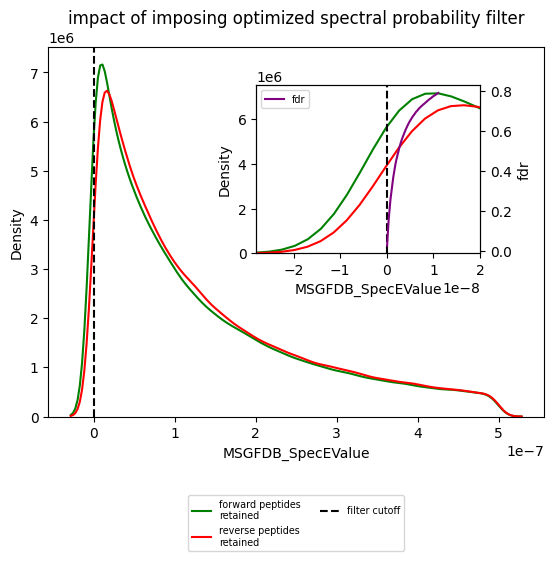

In [41]:
#initial guess at a log10 spectral probability filter value
initial_specprob_filter = -15

#perform optimization
optimization = agg_func.optimize_specFilt(initial_specprob_filter,forward_peptides,reversed_peptides)

#visualize optimization
optimization_fig = agg_func.visualize_optimization(optimization,forward_peptides,reversed_peptides)

del initial_specprob_filter

Apply the filter to the dataset and recalculate peptide and spectral FDR

In [42]:
#Filter the data according to the filter and recalculate FDR
forward_peptides = forward_peptides[
    (forward_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

reversed_peptides = reversed_peptides[
    (reversed_peptides["MSGFDB_SpecEValue"] < 10 ** optimization.x[0])
].copy()

# Calculate FDR
f_spec = (forward_peptides["SpecID"].unique().size)
r_spec = reversed_peptides["SpecID"].unique().size
if (f_spec == 0) & (r_spec == 0):
    fdr_spec = 1
else:
    fdr_spec = (2*r_spec) / (f_spec + r_spec)

f_pep = forward_peptides["Peptide Sequence with Mods"].unique().size
r_pep = reversed_peptides["Peptide Sequence with Mods"].unique().size
if (f_pep == 0) & (r_pep == 0):
    fdr_pep = 1
else:
    fdr_pep = (r_pep) / (f_pep + r_pep)

del f_spec, r_spec, f_pep, r_pep

print("Spectral FDR:",fdr_spec,"\nPeptide FDR:",fdr_pep)


Spectral FDR: 0.04997791380071938 
Peptide FDR: 0.055613538094528105


## 3) Collapse to unique peptides and normalize quantification

Apply log2 transformation and median normalize peptide abundances

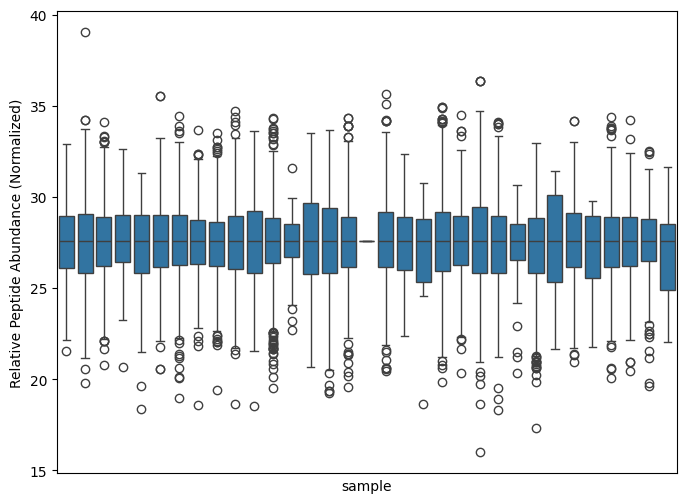

In [43]:
#extract data set id
forward_peptides['processed_DO_id'] = forward_peptides['SpecID'].str.split('_').str[0]

#log2 tranformation
forward_peptides['StatMomentsAreaLog2']=np.log2(forward_peptides['StatMomentsArea'])

# Calculate group-wise (sample wise) median
group_medians = forward_peptides.groupby('processed_DO_id')['StatMomentsAreaLog2'].median()

# Calculate data wide median
all_data_median=forward_peptides['StatMomentsAreaLog2'].median()

# Subtract sample wise median from each value within its group
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides.apply(
    lambda row: row['StatMomentsAreaLog2'] - group_medians[row['processed_DO_id']], axis=1
)

#add back in a data wide median value to avoid negative abundances
forward_peptides['StatMomentsAreaLog+Norm'] = forward_peptides['StatMomentsAreaLog+Norm'] + all_data_median

transformed_abundances_fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='processed_DO_id',y='StatMomentsAreaLog+Norm',data=forward_peptides)
plt.xticks([])
plt.xlabel('sample')
plt.ylabel('Relative Peptide Abundance (Normalized)')

del ax, group_medians, all_data_median, forward_peptides['StatMomentsArea'], forward_peptides['StatMomentsAreaLog2'], reversed_peptides

Sum abundances for peptide sequences that were detected more than once in a dataset, leaving a single abundance value for each peptide in each dataset

In [44]:
#drop SpecID and spectral probability columns since no longer relevant
forward_peptides.drop(['SpecID','MSGFDB_SpecEValue'],axis=1, inplace=True)

#for each peptide sequence with mods, sum the abundances for all scans/identifications
forward_peptides = forward_peptides.groupby(['processed_DO_id','Peptide Sequence with Mods'])['StatMomentsAreaLog+Norm'].sum().to_frame().reset_index()

display(forward_peptides)


,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,AALAANSELMNK,27.600737
1,nmdc:dobj-11-2k6s1505,AFTVDEMR,26.634867
2,nmdc:dobj-11-2k6s1505,AGGSITSSGGVERNDVDYSAVLTK,23.278834
...,...,...,...
12100,nmdc:dobj-11-zn9eyg46,VAELEATTAR,60.339342
12101,nmdc:dobj-11-zn9eyg46,VAELEATTVR,27.188419
12102,nmdc:dobj-11-zn9eyg46,WLWNYYQYYK,22.022224


## 4) Generate protein mappings using both "Razor" and "Sorted List" strategies

Collect peptide to protein mapping information for the passing peptide sequences and the gene annotation information for the related proteins

In [45]:
peptide_protein_mapping = pd.DataFrame(unfilt_res[unfilt_res['Peptide Sequence with Mods'].isin(forward_peptides['Peptide Sequence with Mods'])][['Peptide Sequence with Mods','Protein']].drop_duplicates()).reset_index(drop=True)
peptide_protein_mapping

,Peptide Sequence with Mods,Protein
0,NLTTGPGSAQEAIFNR,nmdc:wfmgan-11-z0q72297.1_004752_2_691
1,TYTLRPGAVAEFEER,nmdc:wfmgan-11-z0q72297.1_013275_1_561
2,ELASSAAYTTIQTVK,nmdc:wfmgan-11-z0q72297.1_056571_1_339
...,...,...
20302,AHLDQIVTR,nmdc:wfmgan-11-z0raab34.1_002480_199_1413
20303,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_005022_699_1082
20304,GEPNLENELWR,nmdc:wfmgan-11-z0raab34.1_024291_3_491


Perform razor protein mapping, which is a method of mapping degenerate peptides (i.e. peptides that map to more than one protein). It can be performed via the razorprotein() function in agg_func.

The rules are as follows:
- If a peptide is unique to a protein, then that is the razor
- If a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the razor
- If a peptide belongs to more than one protein and one of those proteins has has the maximal number of peptides, then that protein is the razor
- If a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then collapse the proteins and gene annotations into single strings
- If a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

In [46]:
razormapping = agg_func.razorprotein(peptide_protein_mapping)
razormapping

,Peptide Sequence with Mods,razor
0,AAAAAIATASR,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,AAAAAIETASR,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,AAAAAVETASR,"nmdc:wfmgan-11-6pq4bd13.1_044073_3_326, nmdc:w..."
...,...,...
5990,YYQDHFGQYGKGDVAGAQK,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
5991,YYSADTLK,"nmdc:wfmgan-11-21ms6426.1_119378_95_340, nmdc:..."
5992,YYSELFGWQVHEVMPTYGLVHTEAGGK,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


Perform sorted list protein mapping, which is a method of mapping degenerate peptides we employ here in order to obtain a single protein identification for each peptide returned. This is not the same as the popularly used 'first hit' strategy although it employs as similar logic, because it doesn't depend on the original search fasta. It can be performed via the sortedproteins() function in agg_func.

It's defined as:

- If a peptide is unique to a protein, then that is the sorted_list protein
- If a peptide belongs to more than one protein, but one of those proteins has a unique peptide, then that protein is the sorted_list protein
- If a peptide belongs to more than one protein and one of those proteins has has the maximal number of peptides, then that is the sorted_list protein
- If a peptide belongs to more than one protein and more than one of those proteins has the maximal number of peptides, then the sorted_list is the first protein in a sorted list of all proteins across datasets
- If a peptide belongs to more than one protein and more than one of those proteins has a unique peptide, then the peptide is removed from analysis because its mapping is inconclusive

In [47]:
sortedmapping = agg_func.sortedprotein(peptide_protein_mapping)
sortedmapping

,Peptide Sequence with Mods,sorted_list_protein
0,AAAAAIATASR,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,AAAAAIETASR,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,AAAAAVETASR,nmdc:wfmgan-11-6pq4bd13.1_044073_3_326
...,...,...
5990,YYQDHFGQYGKGDVAGAQK,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
5991,YYSADTLK,nmdc:wfmgan-11-21ms6426.1_119378_95_340
5992,YYSELFGWQVHEVMPTYGLVHTEAGGK,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


## 5) Perform protein rollup using the "Sorted List" results and summarize into a final aggregated table of relative protein abundance

Combine sortedmapping information with the quantification since sortedmapping returns a single protein for each peptide

In [48]:
#merge needs to be 'right' because some peptides are removed in mapping functions if they have indeterminante mappings
forward_peptides = forward_peptides.merge(sortedmapping,how='right',on=['Peptide Sequence with Mods'])
del razormapping, sortedmapping, peptide_protein_mapping

forward_peptides

,processed_DO_id,Peptide Sequence with Mods,StatMomentsAreaLog+Norm,sorted_list_protein
0,nmdc:dobj-11-jqrf1211,AAAAAIATASR,30.109155,nmdc:wfmgan-11-j69wrb16.1_070513_62_277
1,nmdc:dobj-11-vjmd5h28,AAAAAIETASR,30.839413,nmdc:wfmgan-11-p3dkkz54.1_002072_639_854
2,nmdc:dobj-11-tk9hc081,AAAAAVETASR,29.549325,nmdc:wfmgan-11-6pq4bd13.1_044073_3_326
...,...,...,...,...
10574,nmdc:dobj-11-jqrf1211,YYQDHFGQYGKGDVAGAQK,54.896380,nmdc:wfmgan-11-j69wrb16.1_013078_1_984
10575,nmdc:dobj-11-sx7cyr58,YYSADTLK,29.721791,nmdc:wfmgan-11-21ms6426.1_119378_95_340
10576,nmdc:dobj-11-7psagy79,YYSELFGWQVHEVMPTYGLVHTEAGGK,27.078081,nmdc:wfmgan-11-v53k8v91.1_045759_189_458


De-log the peptide abundances, sum the abundances for each sorted_list protein then relog transform the rolled up protein abundances

In [49]:
#de-log abundance
forward_peptides['StatMomentsAreaNorm']=2**forward_peptides['StatMomentsAreaLog+Norm']
forward_peptides.drop('StatMomentsAreaLog+Norm',axis=1,inplace=True)

#sum abundance for each sorted_list protein in each dataset
prot_info = forward_peptides.columns[~forward_peptides.columns.isin(['StatMomentsAreaNorm','Peptide Sequence with Mods'])].tolist()
protein_abundances = forward_peptides.groupby(prot_info)['StatMomentsAreaNorm'].sum().reset_index()

#re-log2 tranform abundance
protein_abundances['StatMomentsAreaLog+Norm']=np.log2(protein_abundances['StatMomentsAreaNorm'])
protein_abundances.drop('StatMomentsAreaNorm',axis=1,inplace=True)

del prot_info, forward_peptides

protein_abundances

,processed_DO_id,sorted_list_protein,StatMomentsAreaLog+Norm
0,nmdc:dobj-11-2k6s1505,nmdc:wfmgan-11-21ms6426.1_010178_1_894,26.235653
1,nmdc:dobj-11-2k6s1505,nmdc:wfmgan-11-21ms6426.1_035565_3_638,28.531395
2,nmdc:dobj-11-2k6s1505,nmdc:wfmgan-11-6pq4bd13.1_000019_7179_8075,30.681916
...,...,...,...
8029,nmdc:dobj-11-zn9eyg46,nmdc:wfmgan-11-hyze3t58.1_11193_2_448,23.825105
8030,nmdc:dobj-11-zn9eyg46,nmdc:wfmgan-11-hyze3t58.1_20265_2_136,25.801758
8031,nmdc:dobj-11-zn9eyg46,nmdc:wfmgan-11-j69wrb16.1_099538_3_311,60.339342


## Final aggregated table of relative protein abundance

Reformat these results into a proteomic table, where each row indicates a protein and each column indicates a sample/dataset. The values within are log transformed, median normalized relative abundance values. This table or the longform version above can be used in further proteomic analyses

In [50]:
#pivot to wide crosstab
aggregated_proteomic_output = protein_abundances.pivot(index='sorted_list_protein',columns='processed_DO_id',values='StatMomentsAreaLog+Norm')
aggregated_proteomic_output.columns.name = None

aggregated_proteomic_output

,nmdc:dobj-11-2k6s1505,nmdc:dobj-11-2szyc560,nmdc:dobj-11-301yh759,nmdc:dobj-11-3378mg86,nmdc:dobj-11-3ak2bc31,nmdc:dobj-11-4bwzhs42,nmdc:dobj-11-7psagy79,nmdc:dobj-11-7r5yea49,nmdc:dobj-11-7x21d450,nmdc:dobj-11-bxyvx506,...,nmdc:dobj-11-vjmd5h28,nmdc:dobj-11-wcn69x37,nmdc:dobj-11-x6srbx72,nmdc:dobj-11-xm1yjv87,nmdc:dobj-11-y2aefn18,nmdc:dobj-11-yrbs4v96,nmdc:dobj-11-z47wnf07,nmdc:dobj-11-z8hc0j30,nmdc:dobj-11-zhz66007,nmdc:dobj-11-zn9eyg46
sorted_list_protein,,,,,,,,,,,,,,,,,,,,,
nmdc:wfmgan-11-21ms6426.1_000036_702_1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-21ms6426.1_000053_3_563,NaN,NaN,NaN,NaN,NaN,NaN,111.54655,NaN,NaN,NaN,...,103.969350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-21ms6426.1_000057_4146_5369,NaN,31.321929,28.416203,28.786161,NaN,NaN,31.29260,NaN,NaN,55.20339,...,30.487015,26.597519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nmdc:wfmgan-11-z0raab34.1_148395_2_283,NaN,60.829026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_160266_3_278,NaN,27.827188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nmdc:wfmgan-11-z0raab34.1_167280_3_278,NaN,24.794214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 6) Find additional datasets across omics types in NMDC that share relevant KEGG IDs with this study

After aggregation, the datasets can be compared analytically and the results can be used to search for other NMDC datasets that share relevant pathways. This approach takes advantage of the NMDC set `functional_annotation_agg`. 

Examine the information in 'Functional Annotation GFF' files, which contains the gene annotations associated with these proteins

In [23]:
annotation_input_df = data_objects[(data_objects['data_object_type']=='Functional Annotation GFF') & (data_objects['biosample_id'].isin(proteomic_output_df['biosample_id'].unique().tolist()))].reset_index(drop=True)
display(annotation_input_df)

,id,name,description,file_size_bytes,data_object_type,type,md5_checksum,url,was_generated_by,biosample_id,alternative_identifiers,in_manifest,data_category
0,nmdc:dobj-11-cncace51,nmdc_wfmgan-11-z0q72297.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-z0q72...,41027989.0,Functional Annotation GFF,nmdc:DataObject,d4f6008ecb2a990fdd533365d16f547b,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-kcdh3w94,NaN,NaN,NaN
1,nmdc:dobj-11-c24s6186,nmdc_wfmgan-11-ewrwts75.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-ewrwt...,114196066.0,Functional Annotation GFF,nmdc:DataObject,3049a60a48baca9133461a7cde827b6f,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-1p0tct86,NaN,NaN,NaN
2,nmdc:dobj-11-p55wx268,nmdc_wfmgan-11-vcrp9p47.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-vcrp9...,36135504.0,Functional Annotation GFF,nmdc:DataObject,56ca7bb11c7a299af52bfb23d2bfefa0,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-2fw5j754,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,nmdc:dobj-11-f6n2bs50,nmdc_wfmgan-11-v53k8v91.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-v53k8...,69287553.0,Functional Annotation GFF,nmdc:DataObject,4c2d463ad8a820bcbab591e6c398932e,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-3pvn5d70,NaN,NaN,NaN
31,nmdc:dobj-11-sr07nm98,nmdc_wfmgan-11-b431tg70.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-b431t...,66352443.0,Functional Annotation GFF,nmdc:DataObject,d29c8717338d7b1c47b07182cd576443,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-amdcp906,NaN,NaN,NaN
32,nmdc:dobj-11-2yvsr009,nmdc_wfmgan-11-z0raab34.1_functional_annotatio...,Functional Annotation for nmdc:wfmgan-11-z0raa...,59167081.0,Functional Annotation GFF,nmdc:DataObject,41a3766ddaf4dc0b2f20a3ce0d69647c,https://data.microbiomedata.org/data/nmdc:ompr...,NaN,nmdc:bsm-13-vqk1y255,NaN,NaN,NaN


In [34]:
#example annotation file
annotation_file=annotation_input_df.iloc[0]["url"]
print(annotation_file)

#pull data as TSV using url
for tsv in [annotation_file]:
    response = requests.get(tsv)
    data = StringIO(response.text)
    df = pd.read_csv(data,sep='\t',header=None,low_memory=False)
    data.close()
    display(df)
    print(df.iloc[0,8])
    del response, data, df, tsv

del annotation_file

https://data.microbiomedata.org/data/nmdc:omprc-13-z37b9193/nmdc:wfmgan-11-z0q72297.1/nmdc_wfmgan-11-z0q72297.1_functional_annotation.gff


,0,1,2,3,4,5,6,7,8
0,nmdc:wfmgan-11-z0q72297.1_000001,Prodigal v2.6.3_patched,CDS,7,501,52.6,-,0,ID=nmdc:wfmgan-11-z0q72297.1_000001_7_501;tran...
1,nmdc:wfmgan-11-z0q72297.1_000001,Prodigal v2.6.3_patched,CDS,822,2396,135.7,+,0,ID=nmdc:wfmgan-11-z0q72297.1_000001_822_2396;t...
2,nmdc:wfmgan-11-z0q72297.1_000001,Prodigal v2.6.3_patched,CDS,2472,2807,23.8,+,0,ID=nmdc:wfmgan-11-z0q72297.1_000001_2472_2807;...
...,...,...,...,...,...,...,...,...,...
144459,nmdc:wfmgan-11-z0q72297.1_118419,Prodigal v2.6.3_patched,CDS,2,199,19.4,-,0,ID=nmdc:wfmgan-11-z0q72297.1_118419_2_199;tran...
144460,nmdc:wfmgan-11-z0q72297.1_118420,Prodigal v2.6.3_patched,CDS,2,199,22.4,-,0,ID=nmdc:wfmgan-11-z0q72297.1_118420_2_199;tran...
144461,nmdc:wfmgan-11-z0q72297.1_118421,Prodigal v2.6.3_patched,CDS,73,201,6.0,-,0,ID=nmdc:wfmgan-11-z0q72297.1_118421_73_201;tra...


ID=nmdc:wfmgan-11-z0q72297.1_000001_7_501;translation_table=11;start_type=ATG;product=uncharacterized protein;product_source=KO:K09129;cath_funfam=3.40.1520.10;cog=COG1839;ko=KO:K09129;pfam=PF04008;superfamily=103165


Extract information from all 33 annotation files (this takes a while to run) and merge the annotation information with the protein abundances

In [52]:
#get gene annotation information for proteins
gene_annotations = annotation_input_df[["id", "url"]].drop_duplicates().reset_index(drop=True)

gene_annotations = agg_func.tsv_extract(
    pd_df=gene_annotations,\
    identifier_col='id',\
    url_col='url',\
    extract_cols=[8],\
    header=None
)

#name gene annotation columns
gene_annotations = gene_annotations.set_axis(['gene_info','id_col'], axis=1)

# split the gene_info string into a dictionary and create new columns using title=value; as format
def split_to_dict(row):
    return dict(item.split('=') for item in row.split(';'))
gene_annotations = gene_annotations.loc[:,'gene_info'].apply(split_to_dict).apply(pd.Series)

#join with protein abundance info
protein_abundances = gene_annotations.merge(protein_abundances,left_on='ID',right_on='sorted_list_protein').drop('ID',axis=1)

#get biosample id
protein_abundances = protein_abundances.merge(proteomic_output_df[['biosample_id','id']], right_on='id',left_on='processed_DO_id').drop('id',axis=1)

#subset to desired columns
protein_abundances = protein_abundances[['product','product_source','processed_DO_id','biosample_id','sorted_list_protein','StatMomentsAreaLog+Norm']]

protein_abundances


/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_aggregation_and_visualization/python/aggregation_functions.py:76: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tsv_df = pd.read_csv(tsv_data,sep='\t',header=header)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_aggregation_and_visualization/python/aggregation_functions.py:76: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tsv_df = pd.read_csv(tsv_data,sep='\t',header=header)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_aggregation_and_visualization/python/aggregation_functions.py:76: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  tsv_df = pd.read_csv(tsv_data,sep='\t',header=header)
/Users/ober845/Library/CloudStorage/OneDrive-PNNL/Desktop/nmdc_notebooks/proteomic_ag

,product,product_source,processed_DO_id,biosample_id,sorted_list_protein,StatMomentsAreaLog+Norm
0,integrase/recombinase XerD,KO:K04763,nmdc:dobj-11-wcn69x37,nmdc:bsm-13-kcdh3w94,nmdc:wfmgan-11-z0q72297.1_010286_302_697,28.206306
1,hypothetical protein,Hypo-rule applied,nmdc:dobj-11-wcn69x37,nmdc:bsm-13-kcdh3w94,nmdc:wfmgan-11-z0q72297.1_013275_1_561,89.573315
2,NAD+-dependent secondary alcohol dehydrogenase...,KO:K18382,nmdc:dobj-11-wcn69x37,nmdc:bsm-13-kcdh3w94,nmdc:wfmgan-11-z0q72297.1_016343_3_572,25.193503
...,...,...,...,...,...,...
8029,topoisomerase IV subunit B,KO:K02622,nmdc:dobj-11-qw8th334,nmdc:bsm-13-c0xjg970,nmdc:wfmgan-11-e98mdq66.1_18963_2_271,18.662187
8030,chaperonin GroEL,KO:K04077,nmdc:dobj-11-qw8th334,nmdc:bsm-13-c0xjg970,nmdc:wfmgan-11-e98mdq66.1_36743_1_282,28.401550
8031,hypothetical protein,Hypo-rule applied,nmdc:dobj-11-nj004g50,nmdc:bsm-13-mvpx4z13,nmdc:wfmgan-11-wcanxp61.1_96221_66_278,27.600737


Gather biosample metadata via the NMDC API `collection` endpoint, which can be done using the function get_id_results() in api_func. Assess the range of collection depth and merge protein abundance information with biosample metadata

In [70]:
#collect biosample metadata via the API
biosamples = api_func.get_id_results(newest_results = protein_abundances.to_dict(orient='records'), id_field = 'biosample_id', query_collection = 'biosample_set', match_id_field = 'id', query_fields = 'id,depth.has_numeric_value')
biosamples = pd.json_normalize(biosamples).drop_duplicates()

display(biosamples[['depth.has_numeric_value']].value_counts().reset_index())

#merge biosample metadata and protein abundance
protein_abundances = protein_abundances.merge(pd.DataFrame(biosamples),left_on='biosample_id',right_on='id').drop('id',axis=1)
del biosamples

,depth.has_numeric_value,count
0,0.0,6
1,0.3,6
2,0.4,6
3,0.1,5
4,0.2,5
5,0.5,5


Calculate average abundance (area under the curve) for proteins detected in samples collected at a depth of either 0.0 m or 0.4 m (similar number of samples). Then calculate logfold change, zscore and pvalue. 

NOTE: This notebook is choosing to treat samples collected at the same depth as 'replicates' in order to demonstrate proteomic analyses, despite the fact that these samples also vary on parameters such as date of collection and location. Also please note that there are no missing value filters being applied to this dataset, something that is typically needed in metaproteomic analyses due to frequency of missing values. 

In [71]:
# Pivot dataframe into longform
protein_abundances_analysis = protein_abundances[protein_abundances['depth.has_numeric_value'].isin([0.0,0.4])].groupby(['depth.has_numeric_value','product','product_source','sorted_list_protein'])['StatMomentsAreaLog+Norm'].mean().to_frame('average_area')\
    .reset_index().pivot(index=['product','product_source','sorted_list_protein'],columns='depth.has_numeric_value',values='average_area')

protein_abundances_analysis.columns.name=None
protein_abundances_analysis.reset_index(inplace=True)

# Calculate log fold change values between the averages
protein_abundances_analysis['logfc'] = protein_abundances_analysis[0.4] - protein_abundances_analysis[0.0]
protein_abundances_analysis.dropna(inplace=True)
protein_abundances_analysis.reset_index(inplace=True,drop=True)

#Calculate zscores for these log fold change values
protein_abundances_analysis['zscore']=(protein_abundances_analysis['logfc']-protein_abundances_analysis['logfc'].mean())/protein_abundances_analysis['logfc'].std()

#equate zscores to pvalue
protein_abundances_analysis['pvalue']=stats.norm.sf(abs(protein_abundances_analysis['zscore']))

#report pathway if significance pvalue < 0.05 or 'insignificant' if not
protein_abundances_analysis['significant_pathway']=np.where((protein_abundances_analysis['pvalue'] < 0.05) & (protein_abundances_analysis['logfc'] > 0.5), protein_abundances_analysis['product'],
                                                     np.where((protein_abundances_analysis['pvalue'] < 0.05) & (protein_abundances_analysis['logfc'] < -0.5), protein_abundances_analysis['product'], 'insignificant'))

protein_abundances_analysis

,product,product_source,sorted_list_protein,0.0,0.4,logfc,zscore,pvalue,significant_pathway
0,D-xylose transport system substrate-binding pr...,KO:K10543,nmdc:wfmgan-11-afrz5241.1_001664_3_983,30.783525,25.484786,-5.298739,-0.087314,0.465211,insignificant
1,DNA-binding Lrp family transcriptional regulator,COG1522,nmdc:wfmgan-11-7j1ws791.1_000107_2012_2266,27.163551,39.226902,12.063351,0.639864,0.261131,insignificant
2,DNA-binding Lrp family transcriptional regulator,COG1522,nmdc:wfmgan-11-8zxjs882.1_003982_11_274,83.140304,28.737588,-54.402716,-2.143941,0.016019,DNA-binding Lrp family transcriptional regulator
...,...,...,...,...,...,...,...,...,...
170,uncharacterized protein GlcG (DUF336 family),COG3193,nmdc:wfmgan-11-8zxjs882.1_066439_56_292,28.389595,27.647501,-0.742094,0.103532,0.458770,insignificant
171,uncharacterized protein YpmS,COG4698,nmdc:wfmgan-11-6pq4bd13.1_017589_105_437,29.214654,28.467074,-0.747579,0.103302,0.458862,insignificant
172,uncharacterized protein with GYD domain,COG4274,nmdc:wfmgan-11-j69wrb16.1_067100_2_277,28.336947,29.001274,0.664327,0.162437,0.435481,insignificant


Use a volcano plot to visualize how many proteins are significantly expressed and the magnitude of their fold change. By annotating the gene pathways to which these proteins belong, we can surmise some biological processes most affected by changes in sample depth.

Text(0, 0.5, '-log10(pvalue)')

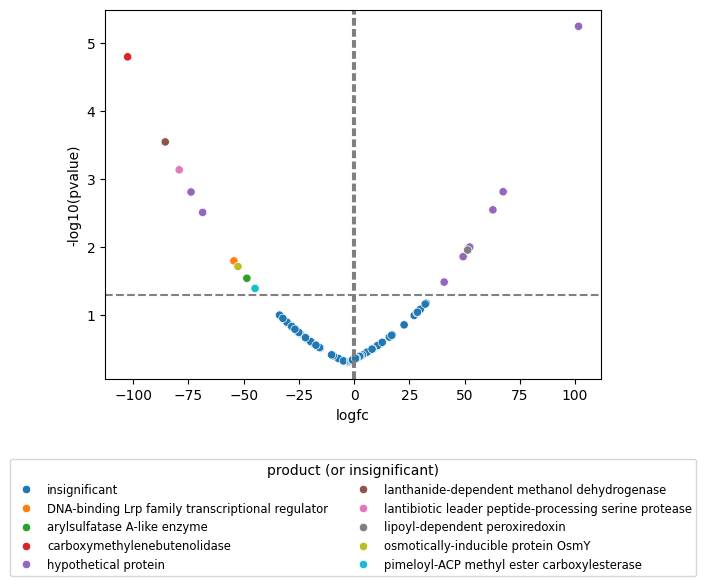

In [72]:
sns.scatterplot(x=protein_abundances_analysis['logfc'],y=-np.log10(protein_abundances_analysis['pvalue']),hue=protein_abundances_analysis['significant_pathway'])
plt.axhline(y=-np.log10(0.05), color='grey', linestyle='--')
plt.axvline(x=-0.5, color='grey', linestyle='--')
plt.axvline(x=0.5, color='grey', linestyle='--')
plt.legend(title='product (or insignificant)',bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2,fontsize='small')
plt.ylabel('-log10(pvalue)')

Identify the gene pathways associated with the 5 largest log fold change values

In [75]:
#identify top 5 largest fold change values and their pathways
protein_abundances_analysis_top5 = protein_abundances_analysis[protein_abundances_analysis['significant_pathway']!='insignificant'].sort_values('logfc',key=abs,ascending=False).head(5).reset_index(drop=True)
protein_abundances_analysis_top5['gene_function_id']='KEGG.ORTHOLOGY:' + protein_abundances_analysis_top5['product_source'].str.split(':').str[1]

protein_abundances_analysis_top5

,product,product_source,sorted_list_protein,0.0,0.4,logfc,zscore,pvalue,significant_pathway,gene_function_id
0,carboxymethylenebutenolidase,KO:K01061,nmdc:wfmgan-11-yjeh0m30.1_065222_3_455,131.124334,28.617579,-102.506755,-4.158687,0.000016,carboxymethylenebutenolidase,KEGG.ORTHOLOGY:K01061
1,hypothetical protein,Hypo-rule applied,nmdc:wfmgan-11-j69wrb16.1_078837_1_417,26.938215,128.511963,101.573748,4.388836,0.000006,hypothetical protein,NaN
2,lanthanide-dependent methanol dehydrogenase,KO:K23995,nmdc:wfmgan-11-afrz5241.1_008650_3_866,110.357132,24.881164,-85.475969,-3.445385,0.000285,lanthanide-dependent methanol dehydrogenase,KEGG.ORTHOLOGY:K23995
3,lantibiotic leader peptide-processing serine p...,KO:K20486,nmdc:wfmgan-11-6pq4bd13.1_002549_3_905,108.058753,28.886567,-79.172186,-3.181363,0.000733,lantibiotic leader peptide-processing serine p...,KEGG.ORTHOLOGY:K20486
4,hypothetical protein,Hypo-rule applied,nmdc:wfmgan-11-b6sp3q07.1_002294_1014_2333,101.265487,27.454658,-73.810828,-2.956813,0.001554,hypothetical protein,NaN


Search for other workflow output files in NMDC that have detected those KO pathways

In [76]:
#find the workflow ids associated with each nonhypothetical pathway
KO_pathway_workflows = api_func.get_next_results(collection='functional_annotation_agg',\
                       filter='{"gene_function_id": {"$in": ["KEGG.ORTHOLOGY:K01061", "KEGG.ORTHOLOGY:K23995","KEGG.ORTHOLOGY:K20486"]}}',\
                        max_page_size=100,fields='')

#find the workflow objects associated with these ids
workflow = api_func.get_id_results(newest_results=KO_pathway_workflows,\
                                id_field="was_generated_by",\
                                query_collection="workflow_execution_set",\
                                match_id_field="id",\
                                query_fields="has_input,has_output")

#find the different output files generated by these workflow objects
outputfiles=api_func.get_id_results(newest_results=workflow,\
                                id_field="has_output",\
                                query_collection="data_object_set",\
                                match_id_field="id",\
                                query_fields="id,data_object_type,url")

#combine information into dataframe
ko_references = pd.DataFrame(KO_pathway_workflows).merge(pd.DataFrame(workflow),left_on='was_generated_by',right_on='id').explode('has_output').drop(['has_input','id'],axis=1)\
    .merge(pd.DataFrame(outputfiles),left_on='has_output',right_on='id').\
        merge(protein_abundances_analysis_top5[['gene_function_id','product']].drop_duplicates(),on='gene_function_id',how='left')

del KO_pathway_workflows, workflow, outputfiles

#filter to a single result file for each potential omic type (proteomics, genomics, transcriptomics)
ko_references = ko_references[ko_references['data_object_type'].isin(['Unfiltered Metaproteomics Results', 'Annotation KEGG Orthology', 'Metatranscriptome Expression'])][['gene_function_id','product','count','id','data_object_type','url']]
display(ko_references)

,gene_function_id,product,count,id,data_object_type,url
0,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,43,nmdc:dobj-11-m1bghr87,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
28,KEGG.ORTHOLOGY:K20486,lantibiotic leader peptide-processing serine p...,17,nmdc:dobj-11-bvge9w42,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
29,KEGG.ORTHOLOGY:K01061,carboxymethylenebutenolidase,24,nmdc:dobj-11-bvge9w42,Annotation KEGG Orthology,https://data.microbiomedata.org/data/nmdc:ompr...
...,...,...,...,...,...,...
107411,KEGG.ORTHOLOGY:K20486,lantibiotic leader peptide-processing serine p...,3,nmdc:dobj-11-301yh759,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...
107421,KEGG.ORTHOLOGY:K20486,lantibiotic leader peptide-processing serine p...,2,nmdc:dobj-11-sx7cyr58,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...
107422,KEGG.ORTHOLOGY:K23995,lanthanide-dependent methanol dehydrogenase,1,nmdc:dobj-11-sx7cyr58,Unfiltered Metaproteomics Results,https://nmdcdemo.emsl.pnnl.gov/proteomics/resu...


Determine how many proteomic ('Unfiltered Metaproteomics Results'), genomic ('Annotation KEGG Orthology') or transcriptomic ('Metatranscriptome Expression') results exist for each of these pathways in NMDC. This peeks into how the schema can be used to expand into multi-omic analyses.

Text(0.5, 0, 'data type')

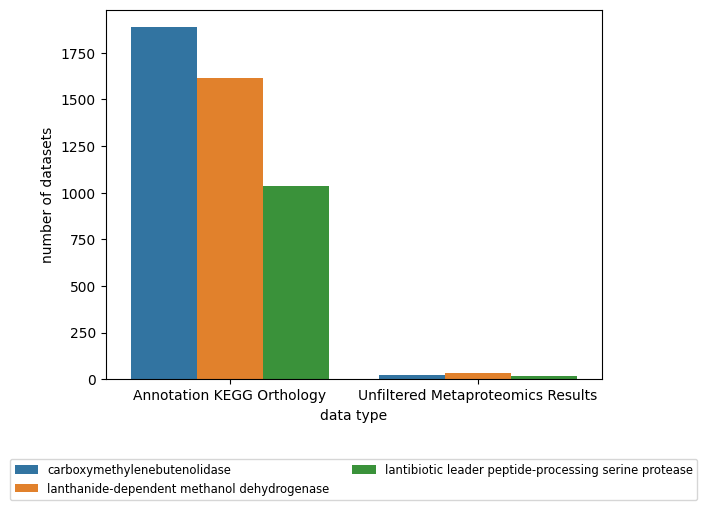

In [79]:
#count how many of these result files exist for each pathway
ko_references_count = ko_references[['product','data_object_type']].value_counts().to_frame().reset_index()

#graph
sns.barplot(data=ko_references_count,x='data_object_type',y='count',hue='product')
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2,fontsize='small')
plt.ylabel('number of datasets')
plt.xlabel('data type')